In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

# In this notebook we are going to create a classification model based on two marco dimensions: weather and holidays

Importing the stock lavel csv and the weather data csv, and public holidays csv

In [78]:
stock_level=pd.read_csv('blood_stock.csv')
weather= pd.read_csv('WeatherDataLagos.csv')
public_holidays=pd.read_excel('Public_Holidays.xlsx')

In [79]:
stock_level.head(3)

,Date,Daily Blood Orders,Daily Blood Donations,Expired units,Blood prev + curr day,Blood stock end day,Unfulfilled orders
0,2016-05-04,1,0,0,0,0,1
1,2016-05-05,0,0,0,0,0,0
2,2016-05-06,0,0,0,0,0,0


# Cleaning and modifying the weather dataset

First of all I am going to transform the column weather in categorical values according to weather conditions 

In [80]:
weather=weather.rename({'weather_description':'weather'},  axis=1)

In [81]:
lo_visibility= ['fog', 'haze','mist','smoke','dust']
clouds = ['drizzle','few clouds','proximity squalls', 'overcast clouds']
light_rain = ['light intensity drizzle','light intensity shower rain','light rain','light thunderstorm','moderate rain']
heavy_rain =['heavy intensity rain', 'heavy intesity shower rain','shower rain','very heavy rain','squalls'] 
thunderstorm= ['thunderstorm','thunderstorm with drizzle','thunderstorm with heavy rain',
               'thunderstorm with light drizzle','thunderstorm with light rain','thunderstorm with rain']


In [82]:
def amend_weather_conditions(x):
    
    if x in lo_visibility:
        return 'low_visibility'
    
    elif x in clouds:
        return 'cloudy'
    
    elif x in light_rain:
        return 'light rain'
    
    elif x in heavy_rain:
        return 'heavy rain'
    
    elif x in thunderstorm:
        return 'Thunderstorm'
    
    else:
        return 'Cleal sky'
    

In [83]:
weather['new_weather_categ']= weather['weather'].apply(lambda i: amend_weather_conditions(i))

In [84]:
weather[881:884]

,dt,dt_iso,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,...,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather,weather_icon,new_weather_categ
881,1139245200,2006-02-06 17:00:00 +0000 UTC,3600,Lagos,6.524379,3.379206,28.46,32.50,27.82,28.80,...,NaN,NaN,NaN,NaN,88,804,Clouds,overcast clouds,04d,cloudy
882,1139248800,2006-02-06 18:00:00 +0000 UTC,3600,Lagos,6.524379,3.379206,27.87,29.77,27.53,28.00,...,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n,Cleal sky
883,1139252400,2006-02-06 19:00:00 +0000 UTC,3600,Lagos,6.524379,3.379206,27.89,29.80,27.57,28.01,...,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n,Cleal sky


In [85]:
#i now create a dictionary where I assciate a categorical value to each weather conditions

whather_conditions= sorted([x for x in weather['new_weather_categ'].unique()])

numeric_categories=[x+1 for x in range(len(whather_conditions))]

dictionary = dict(zip(whather_conditions, numeric_categories))

dictionary

{'Cleal sky': 1,
 'Thunderstorm': 2,
 'cloudy': 3,
 'heavy rain': 4,
 'light rain': 5,
 'low_visibility': 6}

In [86]:
#defining a function that is going to be applied to the weather column in dataframe weather

def apply_numeric_codes(x):
    
    for key, value in dictionary.items():
        if key == x:
            return value

In [87]:
weather['weather_numerical']= weather['new_weather_categ'].apply(lambda i: apply_numeric_codes(i))
#checking whether the function worked correctly (just taking random rows)
weather[50:52]

,dt,dt_iso,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,...,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather,weather_icon,new_weather_categ,weather_numerical
50,1136253600,2006-01-03 02:00:00 +0000 UTC,3600,Lagos,6.524379,3.379206,27.24,31.79,27.05,27.61,...,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n,Cleal sky,1
51,1136257200,2006-01-03 03:00:00 +0000 UTC,3600,Lagos,6.524379,3.379206,27.08,31.68,26.84,27.54,...,NaN,NaN,NaN,82,803,Clouds,broken clouds,04n,Cleal sky,1


In the wheather dataset values are reported hourly, therefore the dataframe is going to be transformed
in daily uints using groupy by date

In [88]:
# using the mode when grouping by, given the fact that we want to report the most frequent value for the specific date

weather['dt']=weather['dt'].apply(lambda x: datetime.datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d'))

In [89]:
group_weather=weather.groupby('dt').mean().reset_index()
group_weather['weather_numerical']=group_weather['weather_numerical'].round(0)

group_weather.head()

,dt,timezone,lat,lon,temp,feels_like,temp_min,temp_max,pressure,sea_level,...,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_numerical
0,2006-01-01,3600.0,6.524379,3.379206,27.290435,32.023478,26.842609,27.614783,1008.652174,NaN,...,89.913043,2.834348,227.217391,0.163333,NaN,NaN,NaN,46.434783,754.826087,2.0
1,2006-01-02,3600.0,6.524379,3.379206,28.450000,32.372500,27.346250,29.153333,1008.375000,NaN,...,84.875000,4.091250,231.583333,0.180000,NaN,NaN,NaN,51.375000,760.333333,2.0
2,2006-01-03,3600.0,6.524379,3.379206,28.065000,31.657917,27.328750,28.587083,1007.500000,NaN,...,86.250000,4.452917,228.625000,NaN,NaN,NaN,NaN,69.791667,784.333333,3.0
3,2006-01-04,3600.0,6.524379,3.379206,28.267917,30.807083,27.205417,28.997500,1006.666667,NaN,...,81.208333,5.172917,240.875000,0.190000,NaN,NaN,NaN,86.125000,784.000000,2.0
4,2006-01-05,3600.0,6.524379,3.379206,27.676250,31.699583,26.938750,28.262083,1006.666667,NaN,...,85.416667,3.370833,226.083333,0.195000,NaN,NaN,NaN,80.291667,757.583333,3.0


In [91]:
columns_to_drop=['timezone','lat','lon', 'temp_min','temp_max', 'sea_level', 'grnd_level', 'wind_deg',
                'rain_1h', 'rain_3h','snow_1h', 'snow_1h', 'snow_3h' , 'clouds_all', 'weather_id']

clean_weather= group_weather.drop(columns_to_drop, axis=1)

In [92]:
print(round(clean_weather.describe(),1))
print('________________________________________________________________')
print('')
print((clean_weather.isna().sum().sort_values(ascending=False))/clean_weather.shape[0])

         temp  feels_like  pressure  humidity  wind_speed  weather_numerical
count  5222.0      5222.0    5222.0    5222.0      5222.0             5222.0
mean     27.1        30.7    1011.8      83.4         3.0                2.7
std       1.3         2.1       1.9       6.8         1.0                1.1
min      23.7        23.0    1005.4      35.9         1.2                1.0
25%      25.9        29.3    1010.4      81.0         2.3                2.0
50%      27.1        31.0    1011.7      84.4         2.8                2.0
75%      28.1        32.2    1013.1      87.3         3.5                3.0
max      30.4        35.7    1017.4      97.9         8.2                6.0
________________________________________________________________

weather_numerical    0.0
wind_speed           0.0
humidity             0.0
pressure             0.0
feels_like           0.0
temp                 0.0
dt                   0.0
dtype: float64


# Going to add the public holidays dataset

In [93]:
public_holidays= public_holidays.dropna(how='any',axis=0)
public_holidays.head(3)

,Date_holiday,Day,Holiday,Type
0,2016-01-01,Friday,New Year's Day,Public Holiday
1,2016-02-14,Sunday,Valentine's Day,Observance
2,2016-03-06,Sunday,Mothering Sunday,Observance


# Merging the Dataframe of weather, blood stock level, and public  holidays on dates and creating a base for implementing models

In [94]:
dataset=pd.merge(stock_level, clean_weather , left_on='Date',right_on='dt',how='left')
dataset.drop('dt', axis=1, inplace=True)
dataset['Date']=  pd.to_datetime(dataset['Date'])

final=pd.merge(dataset, public_holidays[['Date_holiday','Type']],left_on='Date',right_on='Date_holiday',how='left')

final.drop('Date_holiday', axis=1, inplace=True)
final['Type']=final['Type'].transform(lambda x: x.fillna('A-Normal Day'))

print((final.isna().sum().sort_values(ascending=False))/final.shape[0])

Type                     0.0
weather_numerical        0.0
wind_speed               0.0
humidity                 0.0
pressure                 0.0
feels_like               0.0
temp                     0.0
Unfulfilled orders       0.0
Blood stock end day      0.0
Blood prev + curr day    0.0
Expired units            0.0
Daily Blood Donations    0.0
Daily Blood Orders       0.0
Date                     0.0
dtype: float64


# Transforming the variable public_holidays from categorical to numerical

In [95]:
def apply_numeric_codes(x):
    
    for key, value in dictionary.items():
        if key == x:
            return value

In [96]:
type_of_holidays= sorted([x for x in final['Type'].unique()])
numeric_holidays=[x+1 for x in range(len(type_of_holidays))]

dictionary = dict(zip(type_of_holidays, numeric_holidays))
dictionary

{'A-Normal Day': 1,
 'Local holiday': 2,
 'Observance': 3,
 'Observance, Christian': 4,
 'Public Holiday': 5,
 'Season': 6}

In [97]:
final['holidays_type']= final['Type'].apply(lambda i: apply_numeric_codes(i))
#checking whether the function worked correctly (just taking random rows)
final[602:604]

,Date,Daily Blood Orders,Daily Blood Donations,Expired units,Blood prev + curr day,Blood stock end day,Unfulfilled orders,temp,feels_like,pressure,humidity,wind_speed,weather_numerical,Type,holidays_type
602,2017-12-26,1,0,0,255,254,0,26.715417,28.381250,1011.333333,65.708333,2.311667,5.0,Public Holiday,5
603,2017-12-27,0,1,0,255,255,0,26.547500,27.927917,1011.125000,62.208333,1.925833,6.0,A-Normal Day,1


# Implementation of the model step 1: determining the target variable

The end day stock level is calculated following the logic that the it cannot go below zero, meaning that 
whenever the blood bank has no units of blood stock available, simply it cannot meet demand and the stock
level remains accordingly zero. Furthermore, it is assumed that the unfulfilled orders (so
orders that a blood bank cannot meet on a specific day because of the lack of blood stock), won't be carried forward
to the next days.

A new variable was therefore created in the dataset called: 'Unfulfilled Orders'

The implementation of the model is aimed at analyzing the factors that can have influence the levels of unfulfilled
Orders


unfulfilled orders median:  5.0
unfulfilled orders 75th perc:  12.0


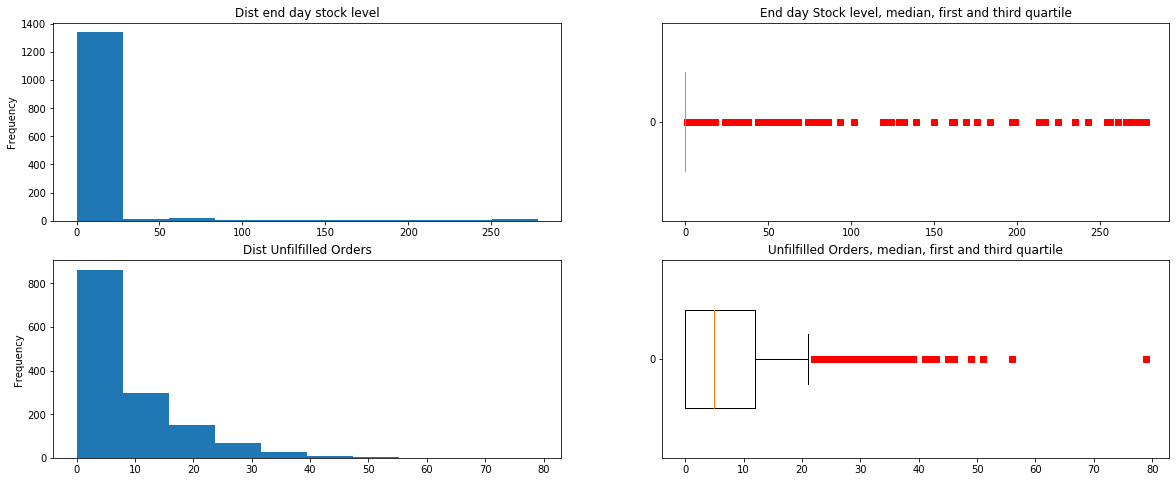

In [98]:
fig = plt.figure(figsize=(20,8))

ax1= fig.add_subplot(2,2,1)
ax2= fig.add_subplot(2,2,2)
ax3= fig.add_subplot(2,2,3)
ax4= fig.add_subplot(2,2,4)

ax1.hist(final['Blood stock end day'])
ax1.set_title('Dist end day stock level')
ax1.set_ylabel('Frequency')
ax2.boxplot(final['Blood stock end day'], False, sym='rs', vert=False, whis=0.75, positions=[0], widths=[0.5])
ax2.set_title('End day Stock level, median, first and third quartile')

ax3.hist(final['Unfulfilled orders'])
ax3.set_title('Dist Unfilfilled Orders')
ax3.set_ylabel('Frequency')
ax4.boxplot(final['Unfulfilled orders'], False, sym='rs', vert=False, whis=0.75, positions=[0], widths=[0.5])
ax4.set_title('Unfilfilled Orders, median, first and third quartile')

print('unfulfilled orders median: ',final['Unfulfilled orders'].median())
print('unfulfilled orders 75th perc: ',final['Unfulfilled orders'].quantile(0.75))



The histogram of the unfulfilled orders shows that in most of the cases the obeservations are btweeen 0 and 8;
Furthermore, the boxplot provides further inishights showing that the median of the obersvatios is arond 5 and 
75% of the obervations (as highlighted by the 75th percentile are between 0 and 12)

We can therefore divide the unfulfilled orders in three macrocategories:
    
a) Cagegory 0 = which is an 'Ordinary' scenario when the blood banks manages to meet the demand

b) Category 1= unfulfilled orders between and including 1 and 5 (the median) - understock- low critical

c) Category 2= unfulfilled orders between and including 6 and 12 (the 75th perc) - understock-  Critical

d) Category 3= unfulfilled orders > 12- understock-  Very critical


In [99]:
def transform_unfufilled_oders(x):
    
    if x == 0:
        return 0
    elif x >=1 and x <=5:
        return 1
    elif x >=6 and x <=12:
        return 2
    else:
        return 3

In [100]:
final['Unfulfilled'] = final['Unfulfilled orders'].apply(lambda i: transform_unfufilled_oders(i))

#check that it worked correctly
final[756:759]

,Date,Daily Blood Orders,Daily Blood Donations,Expired units,Blood prev + curr day,Blood stock end day,Unfulfilled orders,temp,feels_like,pressure,humidity,wind_speed,weather_numerical,Type,holidays_type,Unfulfilled
756,2018-05-29,1,0,0,0,0,1,26.429583,30.471250,1014.000000,89.041667,2.900833,2.0,Public Holiday,5,1
757,2018-05-30,7,0,0,0,0,7,26.313750,30.628750,1013.583333,88.083333,2.268750,3.0,A-Normal Day,1,2
758,2018-05-31,6,1,0,1,0,5,27.301667,32.322083,1013.458333,86.625000,1.842917,2.0,A-Normal Day,1,1


# Implementation of the model step 2: selecting and transoforming the independent variables/dimensions

In [122]:
#reducing the dataset with the variables relevant for the model

reduced= final.drop(['Date','Daily Blood Orders', 'Daily Blood Donations','Unfulfilled orders','Expired units', 
                       'Blood prev + curr day','Blood stock end day','Type'], axis=1)

reduced.head(2)

,temp,feels_like,pressure,humidity,wind_speed,weather_numerical,holidays_type,Unfulfilled
0,28.996250,34.053750,1012.833333,81.958333,2.403750,2.0,1,1
1,29.569167,34.339583,1011.500000,79.041667,2.660833,2.0,1,0


Normalizing the variables temp, feels-like, pressure, humiduty, and wind-speed

In [123]:
reduced[['temp','feels_like','pressure','humidity','wind_speed']
       ]=reduced[['temp','feels_like','pressure','humidity','wind_speed'
                 ]].apply(lambda x: ((x-x.min())/(x.max()-x.min()))*10)

In [124]:
reduced.head()

,temp,feels_like,pressure,humidity,wind_speed,weather_numerical,holidays_type,Unfulfilled
0,7.883315,8.668327,5.630252,7.046589,1.796563,2.0,1,1
1,8.768755,8.902385,4.285714,6.464226,2.181674,2.0,1,0
2,6.789233,7.365314,3.781513,7.387687,3.229652,3.0,1,0
3,7.634104,7.784981,5.126050,6.405990,2.443201,2.0,1,0
4,6.532938,7.695588,6.008403,7.188020,1.385861,2.0,1,0


Let's first of all analyse the distribution of the target variable to find out whether the observations are equally distributed amongst the four classes

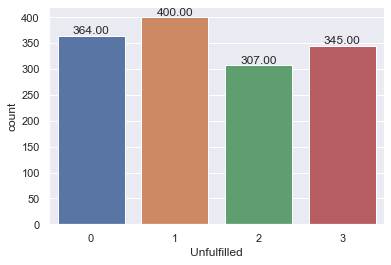

In [155]:
import seaborn as sns

sns.set(style="darkgrid")
ax = sns.countplot(x="Unfulfilled", data=reduced)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', 
                va = 'center', xytext = (0, 5), textcoords = 'offset points')

The dataset is slightly unbalanced, we can therefore use SMOTE to divide the dataset equally amongst the four classes
in the training set and avoid the issues of issues arising from further ubalances when sampling during split in 
Train and Test set

In [156]:
#decleare x and y
y= reduced['Unfulfilled']
x= reduced.drop('Unfulfilled', axis=1)

In [157]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)

# Create training and test set - test size:30% random_state=0
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

columns = X_train.columns

# Apply oversampling ONLY ON training data
os_data_X,os_data_y=os.fit_sample(X_train, Y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Unfulfilled'])

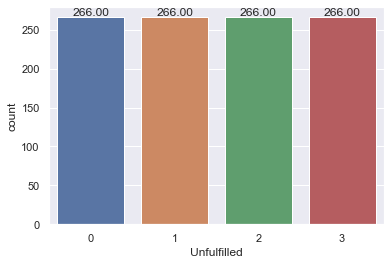

In [158]:
sns.set(style="darkgrid")
ax = sns.countplot(x="Unfulfilled", data=os_data_y)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', 
                va = 'center', xytext = (0, 5), textcoords = 'offset points')

# Classification Modeles : Random Forest, Neural Network, Support Vector Machine

In [159]:
from sklearn.model_selection import GridSearchCV
from sklearn import neural_network
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

We are now going to use GridsearchCV for hyperparameters tuning

1) Neural Networks

In [165]:
parameters = {'solver':['sgd','lbfgs', 'adam'],'activation': ['logistic', 'tanh', 'relu'],
              'alpha': [ 0.1 , 0.01 , 0.001 , 0.0001],'hidden_layer_sizes': np.arange(12, 18)
             }
gridcvneural = GridSearchCV(MLPClassifier(random_state=42),parameters,verbose=1, cv=6)

2) Support Vector

In [162]:
parameters = {'kernel':('linear', 'rbf', 'poly','sigmoid'), 'C': [1, 10, 100, 1000]}
classifier = SVC(random_state=42)
gridsvm = GridSearchCV(classifier, parameters, cv=6)

3)Random Forest

In [168]:
params = {'max_depth': [10,30,50, 70,100, None],
          'max_features': ['auto', 'sqrt'],
          'min_samples_leaf': [1, 2, 4],
          'n_estimators': [100,500,1000, 1500]}
          
gridRF = GridSearchCV(RandomForestClassifier(random_state=42), params, verbose=1, cv=3)

Using girdsearch CV on the entire dataset to find the best parameters that we will later use to define the models 
and fit the Traing Set

In [166]:
#Neural Network

gridcvneural.fit(x,y)

Fitting 6 folds for each of 216 candidates, totalling 1296 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the 

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS RE

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimi

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimi

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimiz

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to co

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to co

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to co

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to co

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimi

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimi

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimiz

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to co

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimi

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimi

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimiz

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimi

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to co

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to co

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimi

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to co

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimi

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimiz

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimi

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimiz

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS RE

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimiz

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimi

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to co

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimi

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to co

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimi

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to co

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimi

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to co

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimi

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to co

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimi

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to co

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimi

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to co

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimi

GridSearchCV(cv=6, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state...
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'activation': ['

In [167]:
#Support vector

gridsvm.fit(x,y)

GridSearchCV(cv=6, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000],
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [169]:
gridRF.fit(x,y)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed: 20.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [172]:
print('Neural Network')
print(gridcvneural.best_score_)
print(gridcvneural.best_params_)

print('')
print('Support Vector')
print(gridsvm.best_score_)
print(gridsvm.best_params_)

print('')
print('Random Forest classifier')
print(gridRF.best_score_)
print(gridRF.best_params_)


Neural Network
0.24717514124293785
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': 13, 'solver': 'sgd'}

Support Vector
0.2846045197740113
{'C': 1, 'kernel': 'sigmoid'}

Random Forest classifier
0.1807909604519774
{'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500}


Implementation of the models

In [173]:
#neural_network
nnt= MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(13,), solver='sgd')

#Support Vector Machine
svm = SVC(kernel="sigmoid", C=1, probability=True)

#Random Forest
rf=RandomForestClassifier(max_depth=50, max_features='auto', min_samples_leaf=1,n_estimators=500)

In [174]:
models=[nnt, svm, rf]
names=['Neural Network', 'Support Vector', 'Random Forest']

In [184]:
for i in range(len(models)):
    
    #Fit the models of training set
    fit_models=[x for x in range(0,len(models))]
    predictions_train=[x for x in range(0,len(models))]
    predictions_test=[x for x in range(0,len(models))]
    
                                        
    fit_models[i]=models[i].fit(os_data_X,os_data_y)
    predictions_train[i]=fit_models[i].predict(os_data_X)
    predictions_test[i]=fit_models[i].predict(X_test)
    
    print('Classification Report for model', names[i])
    print(classification_report(Y_test, predictions_test[i]))  
    print("")
    print('accuracy_score on test set for model', names[i],'is: ',round(accuracy_score(Y_test, predictions_test[i]),3),
         ' while accuracy_score on train set is: ', round(accuracy_score(os_data_y, predictions_train[i]),3))
    print('______________________________________________________________________________________')
    

/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/envs/bts_new/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification Report for model Neural Network
              precision    recall  f1-score   support

           0       0.40      0.38      0.39        99
           1       0.37      0.08      0.13       134
           2       0.24      0.17      0.20        80
           3       0.32      0.69      0.44       112

    accuracy                           0.33       425
   macro avg       0.33      0.33      0.29       425
weighted avg       0.34      0.33      0.29       425


accuracy_score on test set for model Neural Network is:  0.329  while accuracy_score on train set is:  0.319
______________________________________________________________________________________
Classification Report for model Support Vector
              precision    recall  f1-score   support

           0       0.23      0.14      0.17        99
           1       0.32      0.85      0.47       134
           2       0.25      0.01      0.02        80
           3       0.62      0.04      0.08       112

  

/Users/gvaccar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Classification Report for model Random Forest
              precision    recall  f1-score   support

           0       0.33      0.36      0.35        99
           1       0.38      0.31      0.34       134
           2       0.17      0.20      0.19        80
           3       0.38      0.38      0.38       112

    accuracy                           0.32       425
   macro avg       0.32      0.32      0.31       425
weighted avg       0.33      0.32      0.32       425


accuracy_score on test set for model Random Forest is:  0.322  while accuracy_score on train set is:  1.0
______________________________________________________________________________________
